In [68]:
import pickle
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

warnings.filterwarnings('ignore')

# Data reading and visualization

In [69]:
df = pd.read_csv('../datasets/adult.csv', na_values='?', index_col=0)
df.to_csv('adult.csv', index=False)
# drop rows with missing vals
df = df.dropna()
df = df.drop(columns = ['fnlwgt'])

### Description of the dataset

The "education-num" feature is a numerical representation of the "education" feature. Here is the mapping:

In [70]:
df = df.drop(columns = ['education'])

### Target class distribution

In [71]:
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Percentage=%.3f%%' % (k, per))

Class=<=50K, Percentage=75.216%
Class=>50K, Percentage=24.784%


### Select columns with numerical data types

In [72]:
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
subset = df[num_ix]
subset.head()

,educational-num,capital-gain,capital-loss,hours-per-week
age,,,,
25,7,0,0,40
38,9,0,0,50
28,12,0,0,40
44,10,7688,0,40
34,6,0,0,30


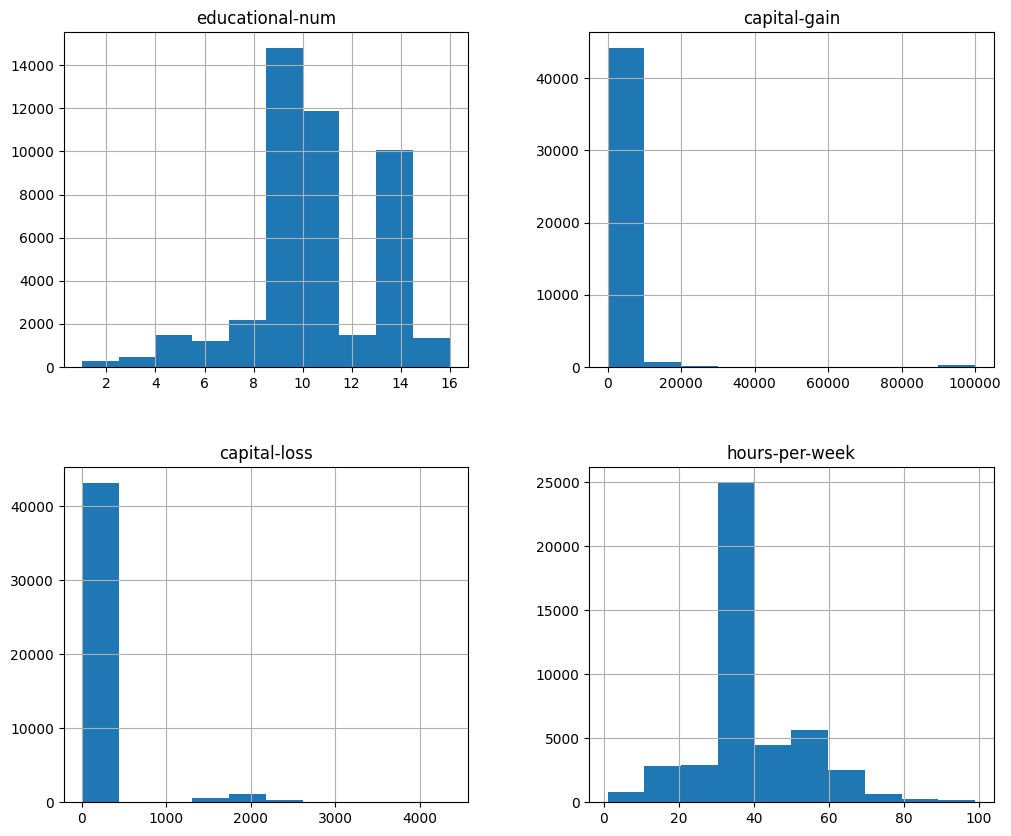

In [73]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
subset.hist(ax=ax)
plt.show()

### Train/Test split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['income']), df['income'],
                                   random_state=42, 
                                   test_size=0.2, 
                                   shuffle=True)
y_label_encoder = LabelEncoder()
y_train = y_label_encoder.fit_transform(y_train)
y_test = y_label_encoder.transform(y_test)

In [75]:
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%s, Percentage=%.3f%%' % (k, per))

Class=1, Percentage=24.892%
Class=0, Percentage=75.108%


In [76]:
cat_ix = X_train.select_dtypes(include=['object', 'bool']).columns
cat_ix

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object')

### Model

In [77]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, verbose=1)
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
pipeline = Pipeline(steps=[('t',ct), ('m',gbc)])

In [78]:
pipeline.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0508            6.96s
         2           0.9971            6.73s
         3           0.9546            6.57s
         4           0.9188            6.47s
         5           0.8891            6.43s
         6           0.8643            6.37s
         7           0.8420            6.34s
         8           0.8238            6.29s
         9           0.8076            6.24s
        10           0.7936            6.21s
        20           0.7130            5.84s
        30           0.6779            5.41s
        40           0.6577            5.02s
        50           0.6428            4.60s
        60           0.6334            4.25s
        70           0.6262            3.89s
        80           0.6195            3.55s
        90           0.6142            3.23s
       100           0.6098            2.92s
       200           0.5832            0.00s


Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('c', OneHotEncoder(),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object')),
                                                 ('n', MinMaxScaler(),
                                                  Index(['educational-num', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object'))])),
                ('m', GradientBoostingClassifier(n_estimators=200, verbose=1))])

In [79]:
x=X_test.iloc[9].values
x = x.reshape((1, -1))
sample_df = pd.DataFrame(x, columns=X_test.columns)
sample_df

,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,Private,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,20,United-States


In [80]:
pipeline.predict_proba(sample_df)

array([[0.91071379, 0.08928621]])

In [81]:
y_test[0] # actual label

0

y_test = 0 -> under $50k

### Model evaluation

In [82]:
X_test.head()

,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
age,,,,,,,,,,,
19,Self-emp-not-inc,6,Married-spouse-absent,Adm-clerical,Unmarried,Amer-Indian-Eskimo,Female,0,0,40,United-States
45,Private,9,Married-civ-spouse,Farming-fishing,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States
47,Private,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
23,Private,10,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,United-States
53,Local-gov,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States


In [83]:
accuracy_score(pipeline.predict(X_test), y_test)

0.8688778330569376

In [84]:
accuracy_score(pipeline.predict(X_train), y_train)

0.8658816375044918

In [85]:
with open('../pretrained_models/pipeline_adult.pkl','wb') as f:
    pickle.dump(pipeline,f)

In [86]:
with open('../pretrained_models/pipeline_adult.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [87]:
pipeline.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

# User case 1

In [88]:
ashley = {'age': 30,
          'workclass': 'Self-emp-not-inc',
          'educational-num': 10,
          'marital-status': 'Never-married',
          'occupation': 'Sales', # so she is a cashier, or independent consultant for Oriflame
          'relationship': 'Own-child',
          'race': 'White',
          'gender': 'Female',
          'capital-gain': 0,
          'capital-loss': 0,
          'hours-per-week': 25,
          'native-country': 'United-States'}
ashley_df = pd.DataFrame(ashley, index=[0])

In [89]:
pipeline.predict_proba(ashley_df)

array([[0.99449592, 0.00550408]])

So the Ashley is destined to be poor ?

In [90]:
ashley_df['workclass'] ='Self-emp-inc'
ashley_df['occupation'] ='Prof-specialty'
ashley_df['educational-num'] = 12
ashley_df['hours-per-week'] = 50
ashley_df['age'] = 32
ashley_df['gender'] = 'Female'
ashley_df['capital-gain']=5120 # 5119 is much less
ashley_df['marital-status'] = 'Married-AF-spouse'
ashley_df['relationship'] = 'Own-child'

In [91]:
pipeline.predict_proba(ashley_df)

array([[0.67787233, 0.32212767]])